<a href="https://colab.research.google.com/github/hamsungmin/DataTrainAnalysis/blob/main/project_week16_%EB%9E%AD%EC%8A%A4%EB%AF%B8%EC%8A%A4%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%9E%AD%EC%B2%B4%EC%9D%B8_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 랭체인 에이전트 Start  - RelayGPT (이어달리기 협업 에이전트) 코드의 완전한 순정 버전
**진행 프로세스**

이 코드는 여러 GPT 에이전트를 단계적으로 협업시키는 **RelayGPT 구조의 LangChain Agent**를 구현한 예시입니다. 주어진 주제(topic)에 대해 아이디어를 생성하고(idea_generator), 그 아이디어를 구체화(elaborator_agent)하며, 계획을 비평(critic_agent)하고, 비평을 반영해 개선(refiner_agent)한 뒤,

마지막으로 전체 과정을 요약(summarizer_agent)합니다.

In [ ]:
!pip install langchain langchain-core langchain-openai langgraph

In [ ]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent # Reverting import to langgraph.prebuilt
from langchain_core.messages import SystemMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
# Colab secrets (왼쪽 패널의 자물쇠 아이콘)에 'OPENAI_API_KEY'를 설정했는지 확인하세요.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

# ======================================================
# 2️⃣ 서브 에이전트 정의 (각각을 Tool로 사용)
# ======================================================

@tool
def elaborator_agent(idea: str) -> str:
    """구체화 담당자: 아이디어 중 하나를 구체적 실행 계획으로 발전시킨다."""
    return f"[구체화] {idea} 중 1번 아이디어를 실제 실행 가능한 프로젝트 계획으로 발전시킵니다. 이 계획은 비평가 에이전트가 검토할 준비가 되었습니다."

@tool
def critic_agent(plan: str) -> str:
    """비평가: 제안된 계획의 약점과 리스크를 분석한다."""
    return f"[비평] {plan}에 대해 두 가지 주요 리스크와 그 해결 방안을 제시합니다. 이 비평은 개선가 에이전트가 반영할 준비가 되었습니다."

@tool
def refiner_agent(critique: str) -> str:
    """개선가: 비평 내용을 반영해 더 완성도 높은 안을 제시한다."""
    return f"[개선안] {critique}을 반영하여 한층 개선된 최종안을 제안합니다. 최종안이 완성되었으니 요약가 에이전트를 호출하여 결과를 요약해야 합니다."

@tool
def summarizer_agent(final_output: str) -> str:
    """요약가: 전체 과정을 요약하고 핵심 문장을 도출한다."""
    return f"[요약] 전체 과정을 요약하면 다음과 같습니다: {final_output}\n핵심 문장: 'AI가 스스로 아이디어를 발전시켜 완성한 협업 결과'. 이제 모든 과정이 완료되었습니다. 최종 답변을 출력하세요."

# ======================================================
# 3️⃣ Agent 생성 (LangGraph V1.0+)
# ==================================================
tools = [elaborator_agent, critic_agent, refiner_agent, summarizer_agent]

# 프롬프트를 ReAct 스타일에 맞게 수정하여 도구 사용을 유도
prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 아이디어를 검증해주고 사업 아이템으로 만들어주는 총괄 매니저야.\n" +
     "다음 단계를 순서대로 수행해야 해:\n" +
     "1. 'elaborator_agent'를 사용하여 아이디어를 구체적인 계획으로 발전시켜.\n" +
     "2. 'critic_agent'를 사용하여 그 계획을 비평해.\n" +
     "3. 'refiner_agent'를 사용하여 비평을 반영해 계획을 개선해.\n" +
     "4. 마지막으로 'summarizer_agent'를 사용하여 전체 과정을 요약하고 핵심 문장을 도출해.\n" +
     "모든 단계가 완료되면 최종 요약을 출력해야 해. 각 도구의 출력을 다음 도구의 입력으로 잘 전달해야 해.\n\n" +
     "Thought: 어떤 도구를 사용해야 할지 항상 생각해야 해.\n" +
     "Action: 사용할 도구의 이름 (예시: elaborator_agent)\n" +
     "Action Input: 도구에 전달할 입력 값\n" +
     "Observation: 도구 실행 결과\n" +
     "...(이 과정을 반복하며 최종 목표에 도달)\n" +
     "Thought: 이제 최종 답변을 알고 있어\n" +
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
    # Removed MessagesPlaceholder for agent_scratchpad as it seems to be handled internally or with different variable name/type
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# ======================================================
# 4️⃣ 실행
# ======================================================
if __name__ == "__main__":
    result = agent_executor.invoke(
        {"messages": [("user", "여행 지역에 맞게 여행 코스를 추천해주는 시스템을 만들거야")]
    })
    print("\n=== 최종 결과 ===\n", result["messages"][-1].content)

/tmp/ipython-input-1962732697.py:66: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 최종 결과 ===
 최종 답변: 여행 지역에 맞게 여행 코스를 추천해주는 시스템의 최종 계획은 다음과 같습니다. 

1. **사용자 입력**: 사용자가 여행하고자 하는 지역과 선호하는 활동을 입력할 수 있도록 하고, 추가적인 질문을 통해 선호를 구체화합니다.
2. **데이터 수집**: 각 지역의 관광지, 음식점, 문화 행사 등의 정보를 신뢰할 수 있는 출처에서 수집하며, 데이터베이스를 정기적으로 업데이트하고 사용자 리뷰를 통해 정보를 보완합니다.
3. **알고리즘 개발**: 사용자의 입력을 바탕으로 최적의 여행 코스를 추천하는 알고리즘을 개발합니다.
4. **사용자 인터페이스**: 사용자가 쉽게 접근하고 사용할 수 있는 웹 또는 모바일 애플리케이션을 개발합니다.
5. **테스트 및 피드백**: 초기 사용자 그룹을 통해 시스템을 테스트하고 피드백을 받아 개선합니다.
6. **런칭**: 최종 제품을 런칭하고 마케팅 전략을 세웁니다.

핵심 문장: 'AI가 스스로 아이디어를 발전시켜 완성한 협업 결과'.


**2. 랭체인 에이전트 Start  - 첨부자료(documents.csv) 이용**

<aside>

**진행 프로세스**

각 문서의 제목과 본문(title, content)을 포함한 CSV 데이터를 기반으로 LangChain Agent를 구성하고, 사용자 질문에 따라 문서 검색 도구(search_docs) 를 자동으로 호출하여 관련 내용을 찾아 응답합니다.  모델, 시스템 프롬프트, 도구 구성은 서비스 목적에 맞게 자유롭게 변경할 수 있습니다.

- **CSV 파일(documents.csv)을 불러와 각 행의 title과 content를 기반으로 LangChain Agent의 검색 데이터를 구성합니다.**
    - search_docs : 문서 검색용 도구 정의
    - 키워드가 포함된 문서를 찾아 제목과 본문 일부(120자)를 반환하고, 검색 결과가 없을 경우 "관련 문서 없음"을 출력하여 예외 처리를 확인
- OpenAI API를 활용해 ChatOpenAI(model="gpt-4o-mini") 모델을 기반으로 LangChain Agent를 생성하고, 시스템 프롬프트를 통해 “회사 내부 문서를 검색하는 어시스턴트” 역할을 지정합니다.
    - agent.invoke() : 사용자 질문을 전달해 실행
    - USER → ASSISTANT → TOOL → ASSISTANT 순으로 메시지 흐름을 출력하고 최종 응답(final_message.content)을 확인하여 Agent 동작이 정상적으로 수행되었는지 검증
</aside>

In [ ]:
import pandas as pd
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_text_splitters import RecursiveCharacterTextSplitter # Corrected import
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# --- 2. CSV 파일 로드 및 Document 객체 생성 ---
df = pd.read_csv('/content/documents.csv', encoding='cp949') # Specify encoding for reading

documents = []
for index, row in df.iterrows():
    documents.append(Document(
        page_content=row['content'],
        metadata={'title': row['title']}
    ))

# --- 3. 텍스트 청크 분할 및 벡터 인덱스 생성 ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# FAISS 벡터 스토어 생성
vectorstore = FAISS.from_documents(chunks, embeddings)

# --- 4. 문서 검색 도구 정의 ---
@tool
def search_docs(query: str) -> str:
    """회사 내부 문서에서 관련 내용을 검색합니다. 키워드를 바탕으로 가장 연관성이 높은 문서를 찾아 반환합니다."""
    docs = vectorstore.similarity_search(query, k=3)
    if not docs:
        return "관련 문서 없음"
    results = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get('title', '제목 없음')
        content_preview = doc.page_content[:120] + '...' if len(doc.page_content) > 120 else doc.page_content
        results.append(f"문서 {i+1} (제목: {title}): {content_preview}")
    return "\n".join(results)

# --- 5. Agent 생성 (LangGraph V1.0+) ---
tools = [search_docs]

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 회사 내부 문서를 검색하는 어시스턴트야. 사용자 질문에 답변하기 위해 반드시 'search_docs' 도구를 사용해야 해.
     관련 정보가 없으면 없다고 말해줘.

     Thought: 사용자 질문에 답변하기 위해 어떤 도구를 사용해야 할지 항상 생각해야 해.
     Action: 사용할 도구의 이름 (예시: search_docs)\n"
     "Action Input: 도구에 전달할 입력 값\n"
     "Observation: 도구 실행 결과\n"
     "...(이 과정을 반복하며 최종 목표에 도달)\n"
     "Thought: 이제 최종 답변을 알고 있어\n"
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# --- 6. 실행 ---
if __name__ == "__main__":
    print("\n=== 문서 검색 에이전트 실행 ===")
    user_question = "협력사 계약 가이드라인 알려줘"
    print(f"사용자 질문: {user_question}")
    result = agent_executor.invoke(
        {"messages": [("user", user_question)]}
    )

    print("\n=== 메시지 흐름 ===")
    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            print(f" ***  USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                # AI message with tool calls represents an action
                print(f" ***  ASSISTANT (Action): {msg.content}")
                print(msg.tool_calls)
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']['query']})")
            else:
                print(f" ***  ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")

    print("\n=== 최종 응답 ===\n", result["messages"][-1].content)

    print("\n" + "="*30 + "\n")

    user_question_2 = "존재하지 않는 기술에 대해 알려줘"
    print(f"사용자 질문: {user_question_2}")
    result_2 = agent_executor.invoke(
        {"messages": [("user", user_question_2)]}
    )
    print("\n=== 메시지 흐름 ===")
    for msg in result_2["messages"]:
        if isinstance(msg, HumanMessage):
            print(f" ***  USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f" ***  ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc.name}({tc.args})")
            else:
                print(f" ***  ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f" ***  TOOL: {msg.content}")
    print("\n=== 최종 응답 ===\n", result_2["messages"][-1].content)

/tmp/ipython-input-1838698588.py:69: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 문서 검색 에이전트 실행 ===
사용자 질문: 협력사 계약 가이드라인 알려줘

=== 메시지 흐름 ===
 ***  USER: 협력사 계약 가이드라인 알려줘
 ***  ASSISTANT (Action): 
[{'name': 'search_docs', 'args': {'query': '협력사 계약 가이드라인'}, 'id': 'call_dHb1hpQSEqfdN9lUlEc9RiEJ', 'type': 'tool_call'}]
  Tool Call: search_docs(협력사 계약 가이드라인)
TOOL: 문서 1 (제목: 협력사 계약 가이드라인): 협력사 선정 및 계약 체결 시 준수해야 할 가이드라인입니다. 1) 협력사 평가 기준: 품질(40%), 가격(30%), 납기준수율(20%), 재무안정성(10%). 2) 계약 절차: 견적 요청 → 평가 → 협상 → 법무...
문서 2 (제목: 영업팀 4분기 목표 및 전략): 2024년 4분기 영업팀 목표는 총 매출 100억원(전년 대비 20% 증가)입니다. 세부 목표: 신규 고객 확보 50개사, 기존 고객 재계약율 85% 이상, 평균 계약 단가 15% 증가. 주요 전략: 1) 엔터프라이...
문서 3 (제목: 사내 교육 프로그램 안내): 2024년 4분기 사내 교육 프로그램을 안내합니다. 1) 직무 교육: 각 직무별 전문성 강화 과정. 개발자는 최신 프레임워크, 마케터는 데이터 분석, 영업은 협상 스킬 등. 2) 리더십 교육: 팀장 이상 대상, 피플...
 ***  ASSISTANT (Final Answer): 협력사 계약 가이드라인에 대한 정보는 다음과 같습니다:

1. **협력사 평가 기준**:
   - 품질: 40%
   - 가격: 30%
   - 납기 준수율: 20%
   - 재무 안정성: 10%

2. **계약 절차**:
   - 견적 요청
   - 평가
   - 협상
   - 법무 검토

이 가이드라인은 협력사 선정 및 계약 체결 시 준수해야 할 사항들을 포함하고 있습니다.

=== 최종 응답 ===
 협력

In [ ]:
# --- 0. 필요 라이브러리 설치 (코랩 환경에서 실행 시) ---
!pip install pandas faiss-cpu langchain-text-splitters langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, 

**3. 랭체인 에이전트 Start**

<aside>

**진행 프로세스**

각 문서의 제목과 본문(title, content)을 포함한 CSV 데이터를 기반으로 LangChain Agent를 구성하고, 사용자 질문에 따라 문서 검색 도구(search_docs) 를 자동으로 호출하여 관련 내용을 찾아 응답합니다.  모델, 시스템 프롬프트, 도구 구성은 서비스 목적에 맞게 자유롭게 변경할 수 있습니다.

- **CSV 파일(documents.csv)의 본문과 부가정보를 Document 객체로 구조화한 후,
텍스트를 청크 단위로 분할하고   벡터 인덱스를 생성합니다.**
    - chunks_data.pkl : 청크 분할 결과 저장
    - faiss.db : 벡터 인덱스 저장 파일
- 멀티 체인을 구성하여 단계별로 문서를 검색하고 응답을 생성합니다.
    - **query_chain** : 사용자 질문에서 핵심 키워드를 추출
    - **search_company_docs** : 추출된 키워드로 문서 검색
    - **summary_chain** : 검색 결과 요약
- create_agent()를 이용해 LLM과 도구를 결합하고,
agent.invoke() 실행 시 질의 분석 → 검색 → 요약 → 최종 응답까지 자동으로 수행되도록 합니다
</aside>

In [ ]:
import pandas as pd
import os
import pickle
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent # Reverting import to langgraph.prebuilt
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# --- 1. CSV 파일 로드 및 Document 객체 생성 ---
df = pd.read_csv('/content/documents.csv', encoding='cp949')

documents = []
for index, row in df.iterrows():
    documents.append(Document(
        page_content=row['content'],
        metadata={'title': row['title'], 'category': row['category'], 'department': row['department']}
    ))

# --- 2. 텍스트 청크 분할 및 벡터 인덱스 생성 ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# FAISS 벡터 스토어 생성
vectorstore = FAISS.from_documents(chunks, embeddings)

# --- 3. 청크 데이터 및 벡터 인덱스 저장 ---
try:
    with open('chunks_data.pkl', 'wb') as f:
        pickle.dump(chunks, f)
    print("chunks_data.pkl 저장 완료.")
except Exception as e:
    print(f"chunks_data.pkl 저장 실패: {e}")

try:
    # FAISS save_local은 'faiss.db' 파일을 직접 생성하지 않고, 디렉토리와 그 안에 index.faiss 및 index.pkl 파일을 생성합니다.
    # 여기서는 'faiss_index'라는 디렉토리로 저장합니다.
    vectorstore.save_local("faiss_index")
    print("faiss_index (faiss_index/index.faiss, faiss_index/index.pkl) 저장 완료.")
except Exception as e:
    print(f"faiss_index 저장 실패: {e}")

# --- 4. 멀티 체인 구성 요소 (Tool) 정의 ---

@tool
def extract_keywords(user_query: str) -> str:
    """사용자의 질문에서 검색에 필요한 핵심 키워드를 3개까지 추출합니다. 쉼표로 구분된 문자열로 반환합니다."""
    keyword_prompt = ChatPromptTemplate.from_messages([
        ("system", "너는 사용자 질문에서 검색에 필요한 핵심 키워드를 추출하는 전문가야. 3개까지 추출하고 쉼표로 구분해서 반환해줘."),
        ("user", "{query}"),
    ])
    chain = keyword_prompt | llm
    response = chain.invoke({"query": user_query})
    return response.content

@tool
def search_company_docs(keywords: str) -> str:
    """추출된 키워드를 사용하여 회사 내부 문서에서 관련 내용을 검색합니다. 가장 연관성 높은 3개의 문서 내용을 반환합니다."""
    docs = vectorstore.similarity_search(keywords, k=3)
    if not docs:
        return "관련 문서 없음"
    results = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get('title', '제목 없음')
        content_preview = doc.page_content[:200] + '...' if len(doc.page_content) > 200 else doc.page_content
        results.append(f"문서 {i+1} (제목: {title}): {content_preview}")
    return "\n".join(results)

@tool
def summarize_results(search_results: str, original_query: str) -> str:
    """검색된 문서를 바탕으로 사용자 질문에 대해 간결하게 요약하여 최종 답변을 생성합니다."""
    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", f"다음은 사용자의 원래 질문입니다: '{original_query}'. 아래 검색 결과를 바탕으로 이 질문에 대해 간결하고 명확하게 답변을 요약해주세요. 관련 정보가 없으면 '관련 정보를 찾을 수 없습니다.'라고 답변해주세요."),
        ("user", "검색 결과:\n{results}"),
    ])
    chain = summary_prompt | llm
    response = chain.invoke({"results": search_results})
    return response.content

# --- 5. Agent 생성 (LangGraph V1.0+) ---
tools = [extract_keywords, search_company_docs, summarize_results]

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 회사 내부 문서를 검색하고 사용자 질문에 답변하는 전문가 어시스턴트야. 다음 단계에 따라 질문에 답변해야 해:\n"
     "1. 사용자 질문에서 핵심 키워드를 추출하기 위해 'extract_keywords' 도구를 사용해.\n"
     "2. 추출된 키워드를 사용하여 'search_company_docs' 도구를 호출해 관련 문서를 검색해.\n"
     "3. 검색된 문서 결과를 바탕으로 'summarize_results' 도구를 호출하여 최종 답변을 요약해.\n"
     "4. 최종 요약 결과를 사용자에게 제공해.\n"
     "각 도구의 출력을 다음 도구의 입력으로 잘 전달해야 해.\n\n"
     "Thought: 어떤 도구를 사용해야 할지 항상 생각해야 해.\n"
     "Action: 사용할 도구의 이름 (예시: extract_keywords)\n"
     "Action Input: 도구에 전달할 입력 값\n"
     "Observation: 도구 실행 결과\n"
     "...(이 과정을 반복하며 최종 목표에 도달)\n"
     "Thought: 이제 최종 답변을 알고 있어\n"
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
    # Removed MessagesPlaceholder for agent_scratchpad to match working example
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# --- 6. 실행 ---
if __name__ == "__main__":
    print("\n=== 멀티 체인 문서 검색 에이전트 실행 ===")
    user_question = "신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘"
    print(f"사용자 질문: {user_question}")
    result = agent_executor.invoke(
        {"messages": [("user", user_question)]}
    )

    print("\n=== 메시지 흐름 ===")
    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})") # Corrected dictionary access
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")

    print("\n=== 최종 응답 ===\n", result["messages"][-1].content)

    print("\n" + "="*30 + "\n")

    user_question_2 = "존재하지 않는 기술에 대해 알려줘"
    print(f"사용자 질문: {user_question_2}")
    result_2 = agent_executor.invoke(
        {"messages": [("user", user_question_2)]}
    )
    print("\n=== 메시지 흐름 ===")
    for msg in result_2["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})") # Corrected dictionary access
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")
    print("\n=== 최종 응답 ===\n", result_2["messages"][-1].content)

chunks_data.pkl 저장 완료.
faiss_index (faiss_index/index.faiss, faiss_index/index.pkl) 저장 완료.

=== 멀티 체인 문서 검색 에이전트 실행 ===
사용자 질문: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘


/tmp/ipython-input-4040793789.py:113: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 메시지 흐름 ===
USER: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘
ASSISTANT (Action): 
  Tool Call: extract_keywords({'user_query': '신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘'})
TOOL: 신제품, 론칭, 프로젝트 계획서
ASSISTANT (Action): 
  Tool Call: search_company_docs({'keywords': '신제품, 론칭, 프로젝트 계획서'})
TOOL: 문서 1 (제목: 신제품 론칭 프로젝트 계획서): 2025년 1분기 출시 예정인 'SmartHome 3.0' 제품 론칭 프로젝트 계획서입니다. 프로젝트 기간은 2024년 11월~2025년 3월(5개월)이며, 총 예산은 8억원입니다. 주요 마일스톤: 1단계(11월) - 시장조사 및 컨셉 확정, 2단계(12월) - 디자인 개발 및 프로토타입 제작, 3단계(1월) - 베타 테스트, 4단계(2월) - 양산 준비 ...
문서 2 (제목: 사내 교육 프로그램 안내): 2024년 4분기 사내 교육 프로그램을 안내합니다. 1) 직무 교육: 각 직무별 전문성 강화 과정. 개발자는 최신 프레임워크, 마케터는 데이터 분석, 영업은 협상 스킬 등. 2) 리더십 교육: 팀장 이상 대상, 피플 매니지먼트, 전략적 사고, 코칭 스킬. 3) 어학 교육: 영어/중국어 회화반 운영, 레벨 테스트 후 반 배정. 회사 지원 50%, 개인 부담 ...
문서 3 (제목: 협력사 계약 가이드라인): 협력사 선정 및 계약 체결 시 준수해야 할 가이드라인입니다. 1) 협력사 평가 기준: 품질(40%), 가격(30%), 납기준수율(20%), 재무안정성(10%). 2) 계약 절차: 견적 요청 → 평가 → 협상 → 법무 검토 → 결재 → 계약 체결. 소액 계약(5천만원 미만)은 팀장 결재, 중액(5천만원~2억)은 본부장 결재, 고액(2억 이상)은 대표이사 결재...
ASSISTANT (Action): 
  Tool Call: summariz

**4. 임베딩 벡터 & 랭체인 & 에이전트**

<aside>

**진행 프로세스**

각 문서의 제목과 본문(title, content)을 포함한 CSV 데이터를 기반으로 LangChain Agent를 구성하고, 사용자 질문에 따라 문서 검색 도구(search_company_docs)를 자동으로 호출하여 관련 내용을 찾아 응답합니다.
모델, 시스템 프롬프트, 도구 구성은 서비스 목적에 맞게 자유롭게 변경할 수 있습니다.

- CSV 파일(documents.csv)의 본문과 부가정보를 Document 객체로 구조화한 후, 텍스트를 청크 단위로 분할하고 벡터 인덱스를 생성합니다.
    - chunks_data_2.pkl : 청크 분할 결과 저장 파일
    - faiss_2.db : 벡터 인덱스 저장 파일
- 멀티 체인을 구성하여 단계별로 문서를 검색하고 응답을 생성합니다.
    - **query_chain** : 사용자 질문에서 핵심 키워드를 추출
    - **search_company_docs** : 추출된 키워드로 문서를 검색
    - **summary_chain** : 검색된 결과를 요약
- create_agent()를 이용해 LLM과 도구를 결합하고, agent.invoke() 실행 시 질의 분석 → 검색 → 요약 → 최종 응답까지 자동으로 수행되도록 구성합니다.
</aside>

In [ ]:
import pandas as pd
import os
import pickle
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# --- 1. CSV 파일 로드 및 Document 객체 생성 ---
df = pd.read_csv('/content/documents.csv', encoding='cp949')

documents = []
for index, row in df.iterrows():
    documents.append(Document(
        page_content=row['content'],
        metadata={'title': row['title'], 'category': row['category'], 'department': row['department']}
    ))

# --- 2. 텍스트 청크 분할 및 벡터 인덱스 생성 ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# FAISS 벡터 스토어 생성
vectorstore = FAISS.from_documents(chunks, embeddings)

# --- 3. 청크 데이터 및 벡터 인덱스 저장 (파일 이름 변경) ---
try:
    with open('chunks_data_2.pkl', 'wb') as f:
        pickle.dump(chunks, f)
    print("chunks_data_2.pkl 저장 완료.")
except Exception as e:
    print(f"chunks_data_2.pkl 저장 실패: {e}")

try:
    # FAISS save_local은 'faiss.db' 파일을 직접 생성하지 않고, 디렉토리와 그 안에 index.faiss 및 index.pkl 파일을 생성합니다.
    # 여기서는 'faiss_index_2'라는 디렉토리로 저장합니다.
    vectorstore.save_local("faiss_index_2")
    print("faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.")
except Exception as e:
    print(f"faiss_index_2 저장 실패: {e}")

# --- 4. 멀티 체인 구성 요소 (Tool) 정의 ---

@tool
def extract_keywords(user_query: str) -> str:
    """사용자의 질문에서 검색에 필요한 핵심 키워드를 3개까지 추출합니다. 쉼표로 구분된 문자열로 반환합니다."""
    keyword_prompt = ChatPromptTemplate.from_messages([
        ("system", "너는 사용자 질문에서 검색에 필요한 핵심 키워드를 추출하는 전문가야. 3개까지 추출하고 쉼표로 구분해서 반환해줘."),
        ("user", "{query}"),
    ])
    chain = keyword_prompt | llm
    response = chain.invoke({"query": user_query})
    return response.content

@tool
def search_company_docs(keywords: str) -> str:
    """추출된 키워드를 사용하여 회사 내부 문서에서 관련 내용을 검색합니다. 가장 연관성 높은 3개의 문서 내용을 반환합니다."""
    docs = vectorstore.similarity_search(keywords, k=3)
    if not docs:
        return "관련 문서 없음"
    results = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get('title', '제목 없음')
        content_preview = doc.page_content[:200] + '...' if len(doc.page_content) > 200 else doc.page_content
        results.append(f"문서 {i+1} (제목: {title}): {content_preview}")
    return "\n".join(results)

@tool
def summarize_results(search_results: str, original_query: str) -> str:
    """검색된 문서를 바탕으로 사용자 질문에 대해 간결하게 요약하여 최종 답변을 생성합니다."""
    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", f"다음은 사용자의 원래 질문입니다: '{original_query}'. 아래 검색 결과를 바탕으로 이 질문에 대해 간결하고 명확하게 답변을 요약해주세요. 관련 정보가 없으면 '관련 정보를 찾을 수 없습니다.'라고 답변해주세요."),
        ("user", "검색 결과:\n{results}"),
    ])
    chain = summary_prompt | llm
    response = chain.invoke({"results": search_results})
    return response.content

# --- 5. Agent 생성 (LangGraph V1.0+) ---
tools = [extract_keywords, search_company_docs, summarize_results]

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 회사 내부 문서를 검색하고 사용자 질문에 답변하는 전문가 어시스턴트야. 다음 단계에 따라 질문에 답변해야 해:\n"
     "1. 사용자 질문에서 핵심 키워드를 추출하기 위해 'extract_keywords' 도구를 사용해.\n"
     "2. 추출된 키워드를 사용하여 'search_company_docs' 도구를 호출해 관련 문서를 검색해.\n"
     "3. 검색된 문서 결과를 바탕으로 'summarize_results' 도구를 호출하여 최종 답변을 요약해.\n"
     "4. 최종 요약 결과를 사용자에게 제공해.\n"
     "각 도구의 출력을 다음 도구의 입력으로 잘 전달해야 해.\n\n"
     "Thought: 어떤 도구를 사용해야 할지 항상 생각해야 해.\n"
     "Action: 사용할 도구의 이름 (예시: extract_keywords)\n"
     "Action Input: 도구에 전달할 입력 값\n"
     "Observation: 도구 실행 결과\n"
     "...(이 과정을 반복하며 최종 목표에 도달)\n"
     "Thought: 이제 최종 답변을 알고 있어\n"
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
    # Removed MessagesPlaceholder for agent_scratchpad to resolve KeyError
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# --- 6. 실행 ---
if __name__ == "__main__":
    print("\n=== 멀티 체인 문서 검색 에이전트 실행 (4번 프로세스) ===")
    user_question = "신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘"
    print(f"사용자 질문: {user_question}")
    result = agent_executor.invoke(
        {"messages": [("user", user_question)]}
    )

    print("\n=== 메시지 흐름 ===")
    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")

    print("\n=== 최종 응답 ===\n", result["messages"][-1].content)

    print("\n" + "="*30 + "\n")

    user_question_2 = "존재하지 않는 기술에 대해 알려줘"
    print(f"사용자 질문: {user_question_2}")
    result_2 = agent_executor.invoke(
        {"messages": [("user", user_question_2)]}
    )
    print("\n=== 메시지 흐름 ===")
    for msg in result_2["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")
    print("\n=== 최종 응답 ===\n", result_2["messages"][-1].content)

chunks_data_2.pkl 저장 완료.
faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.

=== 멀티 체인 문서 검색 에이전트 실행 (4번 프로세스) ===
사용자 질문: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘


/tmp/ipython-input-263719344.py:113: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 메시지 흐름 ===
USER: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘
ASSISTANT (Action): 
  Tool Call: extract_keywords({'user_query': '신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘'})
TOOL: 신제품, 론칭, 프로젝트 계획서
ASSISTANT (Action): 
  Tool Call: search_company_docs({'keywords': '신제품, 론칭, 프로젝트 계획서'})
TOOL: 문서 1 (제목: 신제품 론칭 프로젝트 계획서): 2025년 1분기 출시 예정인 'SmartHome 3.0' 제품 론칭 프로젝트 계획서입니다. 프로젝트 기간은 2024년 11월~2025년 3월(5개월)이며, 총 예산은 8억원입니다. 주요 마일스톤: 1단계(11월) - 시장조사 및 컨셉 확정, 2단계(12월) - 디자인 개발 및 프로토타입 제작, 3단계(1월) - 베타 테스트, 4단계(2월) - 양산 준비 ...
문서 2 (제목: 사내 교육 프로그램 안내): 2024년 4분기 사내 교육 프로그램을 안내합니다. 1) 직무 교육: 각 직무별 전문성 강화 과정. 개발자는 최신 프레임워크, 마케터는 데이터 분석, 영업은 협상 스킬 등. 2) 리더십 교육: 팀장 이상 대상, 피플 매니지먼트, 전략적 사고, 코칭 스킬. 3) 어학 교육: 영어/중국어 회화반 운영, 레벨 테스트 후 반 배정. 회사 지원 50%, 개인 부담 ...
문서 3 (제목: 협력사 계약 가이드라인): 협력사 선정 및 계약 체결 시 준수해야 할 가이드라인입니다. 1) 협력사 평가 기준: 품질(40%), 가격(30%), 납기준수율(20%), 재무안정성(10%). 2) 계약 절차: 견적 요청 → 평가 → 협상 → 법무 검토 → 결재 → 계약 체결. 소액 계약(5천만원 미만)은 팀장 결재, 중액(5천만원~2억)은 본부장 결재, 고액(2억 이상)은 대표이사 결재...
ASSISTANT (Action): 
  Tool Call: summariz

**5. 랭스미스를 이용한 랭체인 에이전 분석**

<aside>

**진행 프로세스**

 RAG 파이프라인의 품질 관리 및 LLM 응답 추적을 위해 **LangSmith 플랫폼을 설치 및 설정**

합니다. LangSmith는 LangChain 기반 애플리케이션의 실행 로그, 체인 구성, 프롬프트 성능 등을 체계적으로 관리할 수 있는 도구로, 사내 AI 챗봇 및 문서 검색 시스템의 품질 평가 환경을 제공합니다.

- **상단의  1,2,3번의 코드중 선택하여 실행된 코드 화면을 첨부하고 해석내용을 첨부합니다.**
</aside>

In [ ]:
import pandas as pd
import os
import pickle
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# LangSmith 환경 변수 설정 (Colab Secrets에 저장된 값 사용)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGSMITH_API")
os.environ["LANGCHAIN_PROJECT"] = "my_langchain_project" # LangSmith에서 확인할 프로젝트 이름
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" # LangSmith에서 확인할 프로젝트 이름


# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# --- 1. CSV 파일 로드 및 Document 객체 생성 ---
df = pd.read_csv('/content/documents.csv', encoding='cp949')

documents = []
for index, row in df.iterrows():
    documents.append(Document(
        page_content=row['content'],
        metadata={'title': row['title'], 'category': row['category'], 'department': row['department']}
    ))

# --- 2. 텍스트 청크 분할 및 벡터 인덱스 생성 ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# FAISS 벡터 스토어 생성
vectorstore = FAISS.from_documents(chunks, embeddings)

# --- 3. 청크 데이터 및 벡터 인덱스 저장 (파일 이름 변경) ---
try:
    with open('chunks_data_2.pkl', 'wb') as f:
        pickle.dump(chunks, f)
    print("chunks_data_2.pkl 저장 완료.")
except Exception as e:
    print(f"chunks_data_2.pkl 저장 실패: {e}")

try:
    # FAISS save_local은 'faiss.db' 파일을 직접 생성하지 않고, 디렉토리와 그 안에 index.faiss 및 index.pkl 파일을 생성합니다.
    # 여기서는 'faiss_index_2'라는 디렉토리로 저장합니다.
    vectorstore.save_local("faiss_index_2")
    print("faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.")
except Exception as e:
    print(f"faiss_index_2 저장 실패: {e}")

# --- 4. 멀티 체인 구성 요소 (Tool) 정의 ---

@tool
def extract_keywords(user_query: str) -> str:
    """사용자의 질문에서 검색에 필요한 핵심 키워드를 3개까지 추출합니다. 쉼표로 구분된 문자열로 반환합니다."""
    keyword_prompt = ChatPromptTemplate.from_messages([
        ("system", "너는 사용자 질문에서 검색에 필요한 핵심 키워드를 추출하는 전문가야. 3개까지 추출하고 쉼표로 구분해서 반환해줘."),
        ("user", "{query}"),
    ])
    chain = keyword_prompt | llm
    response = chain.invoke({"query": user_query})
    return response.content

@tool
def search_company_docs(keywords: str) -> str:
    """추출된 키워드를 사용하여 회사 내부 문서에서 관련 내용을 검색합니다. 가장 연관성 높은 3개의 문서 내용을 반환합니다."""
    docs = vectorstore.similarity_search(keywords, k=3)
    if not docs:
        return "관련 문서 없음"
    results = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get('title', '제목 없음')
        content_preview = doc.page_content[:200] + '...' if len(doc.page_content) > 200 else doc.page_content
        results.append(f"문서 {i+1} (제목: {title}): {content_preview}")
    return "\n".join(results)

@tool
def summarize_results(search_results: str, original_query: str) -> str:
    """검색된 문서를 바탕으로 사용자 질문에 대해 간결하게 요약하여 최종 답변을 생성합니다."""
    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", f"다음은 사용자의 원래 질문입니다: '{original_query}'. 아래 검색 결과를 바탕으로 이 질문에 대해 간결하고 명확하게 답변을 요약해주세요. 관련 정보가 없으면 '관련 정보를 찾을 수 없습니다.'라고 답변해주세요."),
        ("user", "검색 결과:\n{results}"),
    ])
    chain = summary_prompt | llm
    response = chain.invoke({"results": search_results})
    return response.content

# --- 5. Agent 생성 (LangGraph V1.0+) ---
tools = [extract_keywords, search_company_docs, summarize_results]

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 회사 내부 문서를 검색하고 사용자 질문에 답변하는 전문가 어시스턴트야. 다음 단계에 따라 질문에 답변해야 해:\n"
     "1. 사용자 질문에서 핵심 키워드를 추출하기 위해 'extract_keywords' 도구를 사용해.\n"
     "2. 추출된 키워드를 사용하여 'search_company_docs' 도구를 호출해 관련 문서를 검색해.\n"
     "3. 검색된 문서 결과를 바탕으로 'summarize_results' 도구를 호출하여 최종 답변을 요약해.\n"
     "4. 최종 요약 결과를 사용자에게 제공해.\n"
     "각 도구의 출력을 다음 도구의 입력으로 잘 전달해야 해.\n\n"
     "Thought: 어떤 도구를 사용해야 할지 항상 생각해야 해.\n"
     "Action: 사용할 도구의 이름 (예시: extract_keywords)\n"
     "Action Input: 도구에 전달할 입력 값\n"
     "Observation: 도구 실행 결과\n"
     "...(이 과정을 반복하며 최종 목표에 도달)\n"
     "Thought: 이제 최종 답변을 알고 있어\n"
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# --- 6. 실행 ---
if __name__ == "__main__":
    print("\n=== 멀티 체인 문서 검색 에이전트 실행 (LangSmith Tracing 활성화) ===")
    user_question = "신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘"
    print(f"사용자 질문: {user_question}")
    result = agent_executor.invoke(
        {"messages": [("user", user_question)]}
    )

    print("\n=== 메시지 흐름 ===")
    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")

    print("\n=== 최종 응답 ===\n", result["messages"][-1].content)

    print("\n" + "="*30 + "\n")

    user_question_2 = "존재하지 않는 기술에 대해 알려줘"
    print(f"사용자 질문: {user_question_2}")
    result_2 = agent_executor.invoke(
        {"messages": [("user", user_question_2)]}
    )
    print("\n=== 메시지 흐름 ===")
    for msg in result_2["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")
    print("\n=== 최종 응답 ===\n", result_2["messages"][-1].content)


chunks_data_2.pkl 저장 완료.
faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.

=== 멀티 체인 문서 검색 에이전트 실행 (LangSmith Tracing 활성화) ===
사용자 질문: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘


/tmp/ipython-input-2572522734.py:119: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 메시지 흐름 ===
USER: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘
ASSISTANT (Action): 
  Tool Call: extract_keywords({'user_query': '신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘'})
TOOL: 신제품, 론칭, 프로젝트 계획서
ASSISTANT (Action): 
  Tool Call: search_company_docs({'keywords': '신제품, 론칭, 프로젝트 계획서'})
TOOL: 문서 1 (제목: 신제품 론칭 프로젝트 계획서): 2025년 1분기 출시 예정인 'SmartHome 3.0' 제품 론칭 프로젝트 계획서입니다. 프로젝트 기간은 2024년 11월~2025년 3월(5개월)이며, 총 예산은 8억원입니다. 주요 마일스톤: 1단계(11월) - 시장조사 및 컨셉 확정, 2단계(12월) - 디자인 개발 및 프로토타입 제작, 3단계(1월) - 베타 테스트, 4단계(2월) - 양산 준비 ...
문서 2 (제목: 사내 교육 프로그램 안내): 2024년 4분기 사내 교육 프로그램을 안내합니다. 1) 직무 교육: 각 직무별 전문성 강화 과정. 개발자는 최신 프레임워크, 마케터는 데이터 분석, 영업은 협상 스킬 등. 2) 리더십 교육: 팀장 이상 대상, 피플 매니지먼트, 전략적 사고, 코칭 스킬. 3) 어학 교육: 영어/중국어 회화반 운영, 레벨 테스트 후 반 배정. 회사 지원 50%, 개인 부담 ...
문서 3 (제목: 협력사 계약 가이드라인): 협력사 선정 및 계약 체결 시 준수해야 할 가이드라인입니다. 1) 협력사 평가 기준: 품질(40%), 가격(30%), 납기준수율(20%), 재무안정성(10%). 2) 계약 절차: 견적 요청 → 평가 → 협상 → 법무 검토 → 결재 → 계약 체결. 소액 계약(5천만원 미만)은 팀장 결재, 중액(5천만원~2억)은 본부장 결재, 고액(2억 이상)은 대표이사 결재...
ASSISTANT (Action): 
  Tool Call: summariz

In [ ]:
!pip install --upgrade langsmith


In [ ]:
import pandas as pd
import os
import pickle
import langsmith

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# LangSmith 환경 변수 설정 (Colab Secrets에 저장된 값 사용)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "my_langchain_project" # LangSmith에서 확인할 프로젝트 이름
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" # LangSmith에서 확인할 프로젝트 이름


# 코랩 환경변수에서 OPENAI_API_KEY를 가져옵니다.
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# LangSmith 트레이서 생성

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# --- 1. CSV 파일 로드 및 Document 객체 생성 ---
df = pd.read_csv('/content/documents.csv', encoding='cp949')

documents = []
for index, row in df.iterrows():
    documents.append(Document(
        page_content=row['content'],
        metadata={'title': row['title'], 'category': row['category'], 'department': row['department']}
    ))

# --- 2. 텍스트 청크 분할 및 벡터 인덱스 생성 ---
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

# FAISS 벡터 스토어 생성
vectorstore = FAISS.from_documents(chunks, embeddings)

# --- 3. 청크 데이터 및 벡터 인덱스 저장 (파일 이름 변경) ---
try:
    with open('chunks_data_2.pkl', 'wb') as f:
        pickle.dump(chunks, f)
    print("chunks_data_2.pkl 저장 완료.")
except Exception as e:
    print(f"chunks_data_2.pkl 저장 실패: {e}")

try:
    # FAISS save_local은 'faiss.db' 파일을 직접 생성하지 않고, 디렉토리와 그 안에 index.faiss 및 index.pkl 파일을 생성합니다.
    # 여기서는 'faiss_index_2'라는 디렉토리로 저장합니다.
    vectorstore.save_local("faiss_index_2")
    print("faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.")
except Exception as e:
    print(f"faiss_index_2 저장 실패: {e}")

# --- 4. 멀티 체인 구성 요소 (Tool) 정의 ---

@tool
def extract_keywords(user_query: str) -> str:
    """사용자의 질문에서 검색에 필요한 핵심 키워드를 3개까지 추출합니다. 쉼표로 구분된 문자열로 반환합니다."""
    keyword_prompt = ChatPromptTemplate.from_messages([
        ("system", "너는 사용자 질문에서 검색에 필요한 핵심 키워드를 추출하는 전문가야. 3개까지 추출하고 쉼표로 구분해서 반환해줘."),
        ("user", "{query}"),
    ])
    chain = keyword_prompt | llm
    response = chain.invoke({"query": user_query})
    return response.content

@tool
def search_company_docs(keywords: str) -> str:
    """추출된 키워드를 사용하여 회사 내부 문서에서 관련 내용을 검색합니다. 가장 연관성 높은 3개의 문서 내용을 반환합니다."""
    docs = vectorstore.similarity_search(keywords, k=3)
    if not docs:
        return "관련 문서 없음"
    results = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get('title', '제목 없음')
        content_preview = doc.page_content[:200] + '...' if len(doc.page_content) > 200 else doc.page_content
        results.append(f"문서 {i+1} (제목: {title}): {content_preview}")
    return "\n".join(results)

@tool
def summarize_results(search_results: str, original_query: str) -> str:
    """검색된 문서를 바탕으로 사용자 질문에 대해 간결하게 요약하여 최종 답변을 생성합니다."""
    summary_prompt = ChatPromptTemplate.from_messages([
        ("system", f"다음은 사용자의 원래 질문입니다: '{original_query}'. 아래 검색 결과를 바탕으로 이 질문에 대해 간결하고 명확하게 답변을 요약해주세요. 관련 정보가 없으면 '관련 정보를 찾을 수 없습니다.'라고 답변해주세요."),
        ("user", "검색 결과:\n{results}"),
    ])
    chain = summary_prompt | llm
    response = chain.invoke({"results": search_results})
    return response.content

# --- 5. Agent 생성 (LangGraph V1.0+) ---
tools = [extract_keywords, search_company_docs, summarize_results]

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """너는 회사 내부 문서를 검색하고 사용자 질문에 답변하는 전문가 어시스턴트야. 다음 단계에 따라 질문에 답변해야 해:\n"
     "1. 사용자 질문에서 핵심 키워드를 추출하기 위해 'extract_keywords' 도구를 사용해.\n"
     "2. 추출된 키워드를 사용하여 'search_company_docs' 도구를 호출해 관련 문서를 검색해.\n"
     "3. 검색된 문서 결과를 바탕으로 'summarize_results' 도구를 호출하여 최종 답변을 요약해.\n"
     "4. 최종 요약 결과를 사용자에게 제공해.\n"
     "각 도구의 출력을 다음 도구의 입력으로 잘 전달해야 해.\n\n"
     "Thought: 어떤 도구를 사용해야 할지 항상 생각해야 해.\n"
     "Action: 사용할 도구의 이름 (예시: extract_keywords)\n"
     "Action Input: 도구에 전달할 입력 값\n"
     "Observation: 도구 실행 결과\n"
     "...(이 과정을 반복하며 최종 목표에 도달)\n"
     "Thought: 이제 최종 답변을 알고 있어\n"
     "Final Answer: 최종 답변"""
    ),
    MessagesPlaceholder(variable_name="messages"),
    # Removed MessagesPlaceholder for remaining_steps
])

agent_executor = create_react_agent(llm, tools, prompt=prompt)

# --- 6. 실행 ---
if __name__ == "__main__":
    print("\n=== 멀티 체인 문서 검색 에이전트 실행 (LangSmith Tracing 활성화) ===")
    user_question = "신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘"
    print(f"사용자 질문: {user_question}")
    result = agent_executor.invoke(
        {"messages": [("user", user_question)]}
    )

    print("\n=== 메시지 흐름 ===")
    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")

    print("\n=== 최종 응답 ===\n", result["messages"][-1].content)

    print("\n" + "="*30 + "\n")

    user_question_2 = "존재하지 않는 기술에 대해 알려줘"
    print(f"사용자 질문: {user_question_2}")
    result_2 = agent_executor.invoke(
        {"messages": [("user", user_question_2)]}
    )
    print("\n=== 메시지 흐름 ===")
    for msg in result_2["messages"]:
        if isinstance(msg, HumanMessage):
            print(f"USER: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"ASSISTANT (Action): {msg.content}")
                for tc in msg.tool_calls:
                    print(f"  Tool Call: {tc['name']}({tc['args']})")
            else:
                print(f"ASSISTANT (Final Answer): {msg.content}")
        elif isinstance(msg, ToolMessage):
            print(f"TOOL: {msg.content}")
    print("\n=== 최종 응답 ===\n", result_2["messages"][-1].content)

chunks_data_2.pkl 저장 완료.
faiss_index_2 (faiss_index_2/index.faiss, faiss_index_2/index.pkl) 저장 완료.

=== 멀티 체인 문서 검색 에이전트 실행 (LangSmith Tracing 활성화) ===
사용자 질문: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘


/tmp/ipython-input-2988053938.py:123: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_executor = create_react_agent(llm, tools, prompt=prompt)



=== 메시지 흐름 ===
USER: 신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘
ASSISTANT (Action): 
  Tool Call: extract_keywords({'user_query': '신제품 론칭 프로젝트 계획서에 대해 자세히 알려줘'})
TOOL: 신제품, 론칭, 프로젝트 계획서
ASSISTANT (Action): 
  Tool Call: search_company_docs({'keywords': '신제품, 론칭, 프로젝트 계획서'})
TOOL: 문서 1 (제목: 신제품 론칭 프로젝트 계획서): 2025년 1분기 출시 예정인 'SmartHome 3.0' 제품 론칭 프로젝트 계획서입니다. 프로젝트 기간은 2024년 11월~2025년 3월(5개월)이며, 총 예산은 8억원입니다. 주요 마일스톤: 1단계(11월) - 시장조사 및 컨셉 확정, 2단계(12월) - 디자인 개발 및 프로토타입 제작, 3단계(1월) - 베타 테스트, 4단계(2월) - 양산 준비 ...
문서 2 (제목: 사내 교육 프로그램 안내): 2024년 4분기 사내 교육 프로그램을 안내합니다. 1) 직무 교육: 각 직무별 전문성 강화 과정. 개발자는 최신 프레임워크, 마케터는 데이터 분석, 영업은 협상 스킬 등. 2) 리더십 교육: 팀장 이상 대상, 피플 매니지먼트, 전략적 사고, 코칭 스킬. 3) 어학 교육: 영어/중국어 회화반 운영, 레벨 테스트 후 반 배정. 회사 지원 50%, 개인 부담 ...
문서 3 (제목: 협력사 계약 가이드라인): 협력사 선정 및 계약 체결 시 준수해야 할 가이드라인입니다. 1) 협력사 평가 기준: 품질(40%), 가격(30%), 납기준수율(20%), 재무안정성(10%). 2) 계약 절차: 견적 요청 → 평가 → 협상 → 법무 검토 → 결재 → 계약 체결. 소액 계약(5천만원 미만)은 팀장 결재, 중액(5천만원~2억)은 본부장 결재, 고액(2억 이상)은 대표이사 결재...
ASSISTANT (Action): 
  Tool Call: summariz

LangSmith 처리 UI
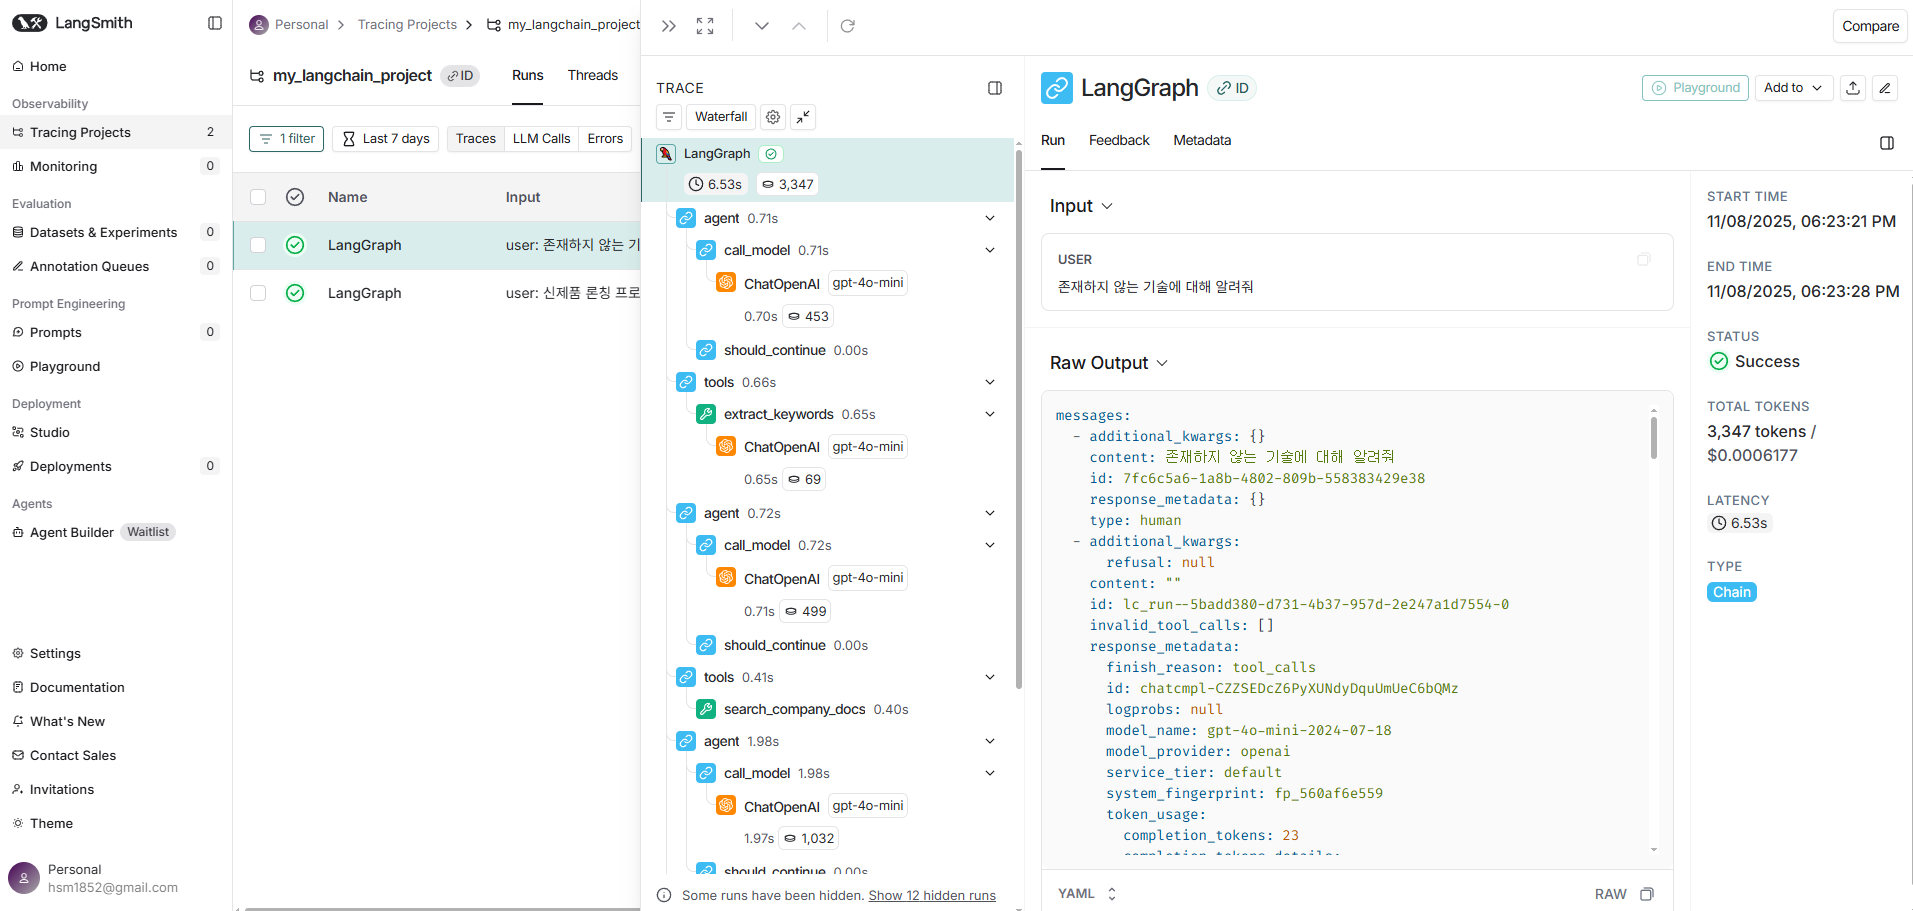